In [3]:
import re
import pandas as pd
import numpy as np
import simplemma
from copy import deepcopy
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import xgboost as xgb
import time
import warnings
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve


In [4]:
stop_words = get_stop_words('uk')

In [5]:
#попередня обробка тексту
def ClearText(text):
    #переведення до нижнього регістру всіх слів
    cleartext = text.lower()
    #print(cleartext)
    #прибирання пустих рядків та розрив рядків
    cleartext = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', cleartext) 
    #залишаємо лише слова, прибираємо пунктуацію та числа
    cleartext = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', cleartext) #deleting symbols  
    #cleartext = cleartext.translate(remove_digits)
    cleartext = cleartext.replace("\\", "")
    cleartext = cleartext.rstrip()
    #прибираємо зайві пробіи
    cleartext = re.sub(" +", " ", cleartext)
    #ділимо речення на список слів, розбиваємо по пробілам
    cleartext = re.split(" ", cleartext)
    #прибираємо стопслова
    cleartext = [word for word in cleartext if word not in stop_words]
    #прибираємо слова, довжина який менше 3 букв
    cleartext = [word for word in cleartext if len(word) > 3]
    #лематизація слів
    cleartext = [simplemma.lemmatize(word, lang='uk') for word in cleartext]
    cleartext = [word.lower() for word in cleartext ]
    return ' '.join(cleartext)

In [6]:
df = pd.read_excel('C:/Users/helen/OneDrive/Рабочий стол/пары/NLP_all.xlsx')
df = df.sample(frac=1) 
df['ClearText'] = df.apply(lambda x: ClearText(x['Comment']), axis=1)
df

C:\Users\helen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Possible nested set at position 30
  if __name__ == "__main__":


,Comment,Category,ClearText
86,Фотосессия !!!,Not_Toxic,фотосессия
1002,"Ооо,Марія, привіт.Я рада тебе чути та дивитися...",Toxic,марія привіт радий чути дивитися прилетіти дит...
901,"Бляха , Дурнев і Бедняков це просто зашквар н...",Toxic,бляха дурнев бедняков зашквар прізвище підходи...
1033,"шарлатанка та розводила, не вірте їй",Toxic,шарлатанка розводити вірити
110,"Питання до косметолога,яка удаляла родимки..як...",Not_Toxic,питання косметолога удаляла родимки кiнцi пере...
...,...,...,...
40,Терфедерація попала на спецобісрації по плану ...,Toxic,терфедерація попал спецобісрації план їбанька
834,Який душевний випуск Вперше побачила вас і під...,Not_Toxic,душевний випуск вперше побачити підписалася хл...
45,Ведучий обосрався аахахаа,Toxic,ведучий обосрався аахахаа
950,Навіщо ви розповідаєте про воєнні справи. Що б...,Toxic,розповідати воєнний справа казати


In [7]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['ClearText'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [8]:
df['TF-IDF'] = list(X_train_tfidf.toarray())

In [9]:
df['category1'] = df.apply(lambda x: 0 if x['Category'] == 'Not_Toxic' else 1, axis=1)

In [10]:
df_train = df.iloc [:round(df.shape[0]*0.75)]
df_test = df.iloc [round(df.shape[0]*0.75):]

# booster='gbtree'

In [13]:
model = xgb.XGBClassifier()
model.fit(list(df_train['TF-IDF']), list(df_train['category1']))
print(model)
# make predictions for test data
y_pred = model.predict(list(df_test['TF-IDF']))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(list(df_test['category1']), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[15:36:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 65.29%


# booster='gblinear'

In [14]:
model = xgb.XGBClassifier(booster='gblinear')
model.fit(list(df_train['TF-IDF']), list(df_train['category1']))
print(model)
y_pred = model.predict(list(df_test['TF-IDF']))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(list(df_test['category1']), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\helen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=-1,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=8, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, subsample=None, tree_method=None,
              validate_parameters=1, verbosity=None)
Acc

# booster='dart'

In [15]:
model = xgb.XGBClassifier(booster='dart')
model.fit(list(df_train['TF-IDF']), list(df_train['category1']))
print(model)
y_pred = model.predict(list(df_test['TF-IDF']))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(list(df_test['category1']), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\helen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy: 65.29%


# Best accuracy

In [74]:
model = xgb.XGBClassifier(base_score=0.5, booster='gblinear', learning_rate=0.1, scale_pos_weight=1,
               n_estimators=250, n_jobs=15)
model.fit(list(df_train['TF-IDF']), list(df_train['category1']))
print(model)
# make predictions for test data
y_pred = model.predict(list(df_test['TF-IDF']))
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(list(df_test['category1']), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\helen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=-1,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=15, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, subsample=None, tree_method=None,
              validate_parameters=1, verbosity=None)
Ac

# XGBRegressor

In [11]:
model = xgb.XGBRegressor()
model.fit(list(df_train['TF-IDF']), list(df_train['category1']))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
expected_y  = list(df_test['category1'])
predicted_y = model.predict(list(df_test['TF-IDF']))

In [18]:
predictions_reg = [round(value) for value in predicted_y]

In [19]:
accuracy = accuracy_score(expected_y, predictions_reg)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.92%


# Binary Classification: XGBoost Hyperparameter Tuning Scenarios by Non-exhaustive Grid Search and Cross-Validation

In [12]:
X_train, y_train, X_test, y_test = list(df_train['TF-IDF']), list(df_train['category1']), list(df_test['TF-IDF']), list(df_test['category1'])

In [13]:
xgbc0 = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='auc', use_label_encoder=False)
xgbc0.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': 'gbtree',
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eval_metric': 'auc'}

In [16]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]
    
default_params['n_jobs'] = [-1]
print(default_params)

{'objective': ['binary:logistic'], 'use_label_encoder': [False], 'base_score': [0.5], 'booster': ['gbtree'], 'colsample_bylevel': [1], 'colsample_bynode': [1], 'colsample_bytree': [1], 'enable_categorical': [False], 'gamma': [0], 'gpu_id': [-1], 'importance_type': [None], 'interaction_constraints': [''], 'learning_rate': [0.300000012], 'max_delta_step': [0], 'max_depth': [6], 'min_child_weight': [1], 'missing': [nan], 'monotone_constraints': ['()'], 'n_estimators': [100], 'n_jobs': [-1], 'num_parallel_tree': [1], 'predictor': ['auto'], 'random_state': [0], 'reg_alpha': [0], 'reg_lambda': [1], 'scale_pos_weight': [1], 'subsample': [1], 'tree_method': ['hist'], 'validate_parameters': [1], 'verbosity': [None], 'eval_metric': ['auc'], 'grow_policy': ['lossguide']}


In [17]:
%%time

#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train)

#results dataframe
df = pd.DataFrame(clf0.cv_results_)


#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)
unseen_predictions = clf0.predict(list(df_test['TF-IDF']))

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
cfm_unseen = confusion_matrix(list(df_test['category1']), unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
accs_unseen = accuracy_score(list(df_test['category1']), unseen_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
f1s_unseen_p1 = f1_score(list(df_test['category1']), unseen_predictions, pos_label=1)
f1s_unseen_p0 = f1_score(list(df_test['category1']), unseen_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
unseen_ras = roc_auc_score(list(df_test['category1']), clf0.predict_proba(list(df_test['TF-IDF']))[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'cfm_unseen': cfm_unseen,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'unseen_accuracy': accs_unseen,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'unseen F1-score label 1': f1s_unseen_p1,
                         'unseen F1-score label 0': f1s_unseen_p0,
                         'test roc auc score': test_ras,
                         'unseen roc auc score': unseen_ras,
                         'best_params': bp}
                         

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Wall time: 4.73 s


In [18]:
accs_test

0.6323024054982818

In [19]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [21]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train)
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    unseen_predictions = clf.predict(list(df_test['TF-IDF']))
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    cfm_unseen = confusion_matrix(list(df_test['category1']), unseen_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    accs_unseen = accuracy_score(list(df_test['category1']), unseen_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    f1s_unseen_p1 = f1_score(list(df_test['category1']), unseen_predictions, pos_label=1)
    f1s_unseen_p0 = f1_score(list(df_test['category1']), unseen_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    unseen_ras = roc_auc_score(list(df_test['category1']), clf.predict_proba(list(df_test['TF-IDF']))[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'cfm_unseen': cfm_unseen,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'unseen_accuracy': accs_unseen,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'unseen F1-score label 1': f1s_unseen_p1,
                                  'unseen F1-score label 0': f1s_unseen_p0,
                                  'test roc auc score': test_ras,
                                  'unseen roc auc score': unseen_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')
    print('Accuracy =', accs_test)
    print('-------------')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 38.76331877708435 seconds
Accuracy = 0.6219931271477663
-------------
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 36.63526678085327 seconds
Accuracy = 0.6254295532646048
-------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 35.702017068862915 seconds
Accuracy = 0.6254295532646048
-------------
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 21.47622275352478 seconds
Accuracy = 0.6254295532646048
-------------
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 23.505112409591675 seconds
Accuracy = 0.6219931271477663
-------------
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 24.888169288635254 seconds
Accuracy = 0.6219931271477663
-------------


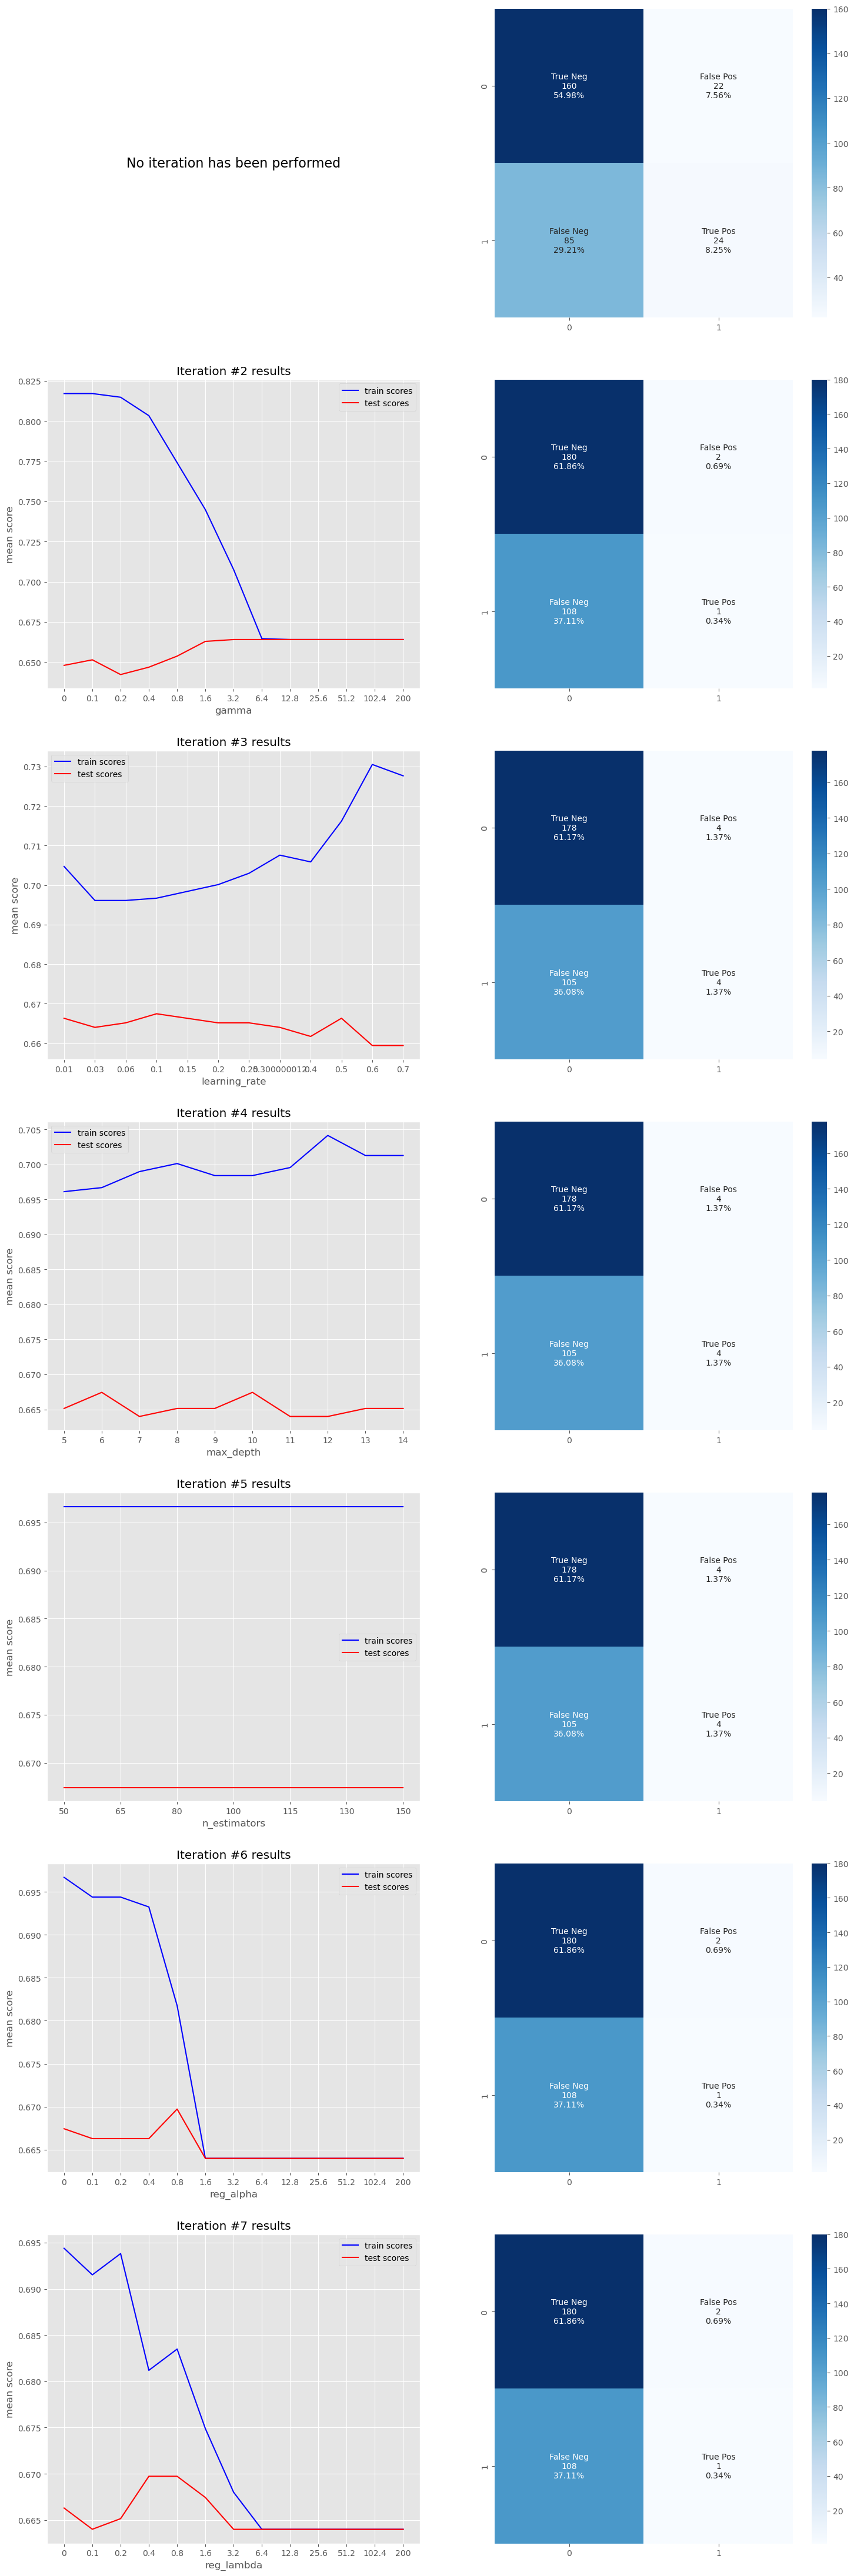

In [22]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show()